In [2]:
filename = "long-timescale_pilot.analysis.h5"

In [5]:
import h5py
import numpy as np

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===filename===
20210517_ChromiumPilot.analysis.h5

===HDF5 datasets===
['node_names', 'track_names', 'track_occupancy', 'tracks']

===locations data shape===
(5983120, 13, 2, 10)

===nodes===
0: head
1: eyeL
2: eyeR
3: thorax
4: abdomen
5: forelegL
6: forelegR
7: midlegL
8: midlegR
9: hindlegL
10: hindlegR
11: wingL
12: wingR



10

In [6]:
frame_count, node_count, _, instance_count = locations.shape

print("frame count:", frame_count)
print("node count:", node_count)
print("instance count:", instance_count)

frame count: 5983120
node count: 13
instance count: 10


In [7]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [89]:
HEAD_INDEX = node_names.index("head")
THORAX_INDEX = node_names.index("thorax")
ABDO_INDEX = node_names.index("abdomen")

time_slice = slice(0,27000)

head_loc = locations[time_slice, HEAD_INDEX, :, :]
thorax_loc = locations[time_slice, THORAX_INDEX, :, :]
abdo_loc = locations[time_slice, ABDO_INDEX, :, :]

In [90]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [91]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Thorax locations')

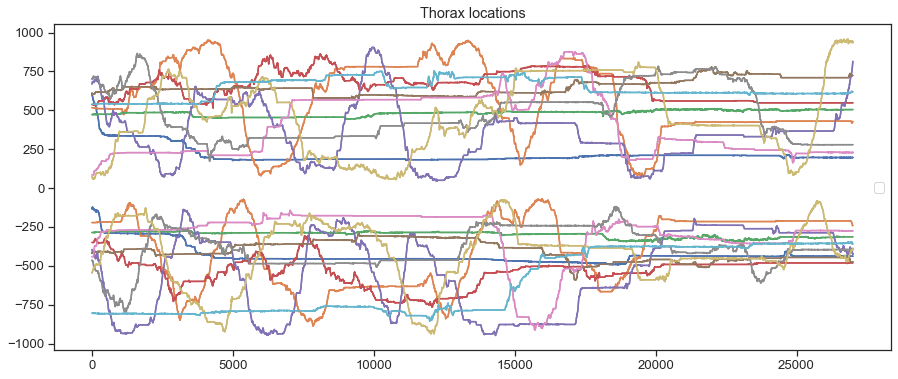

In [98]:
plt.figure()
plt.plot(thorax_loc[:,0,:])
plt.plot(thorax_loc[:,0,:])

plt.plot(-1*thorax_loc[:,1,:])
plt.plot(-1*thorax_loc[:,1,:])

plt.legend(loc="center right")
plt.title('Thorax locations')

Text(0.5, 1.0, 'Thorax tracks')

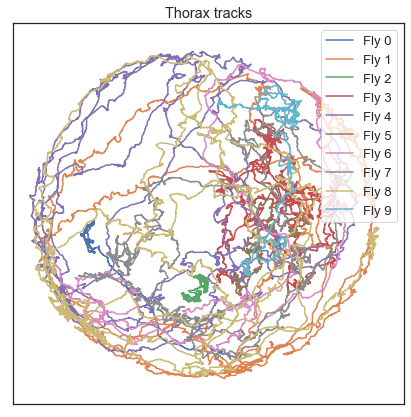

In [137]:
plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0,:],thorax_loc[:,1,:])#, 'y',label='fly-0')
plt.legend(["Fly " + str(i) for i in range(instance_count)])

plt.xlim(0,1024)
plt.xticks([])

plt.ylim(0,1024)
plt.yticks([])
plt.title('Thorax tracks')

In [94]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

In [147]:
fly_num=0

thx_vel_fly = smooth_diff(thorax_loc[:, :, fly_num])


Text(0.5, 1.0, 'Velocity')

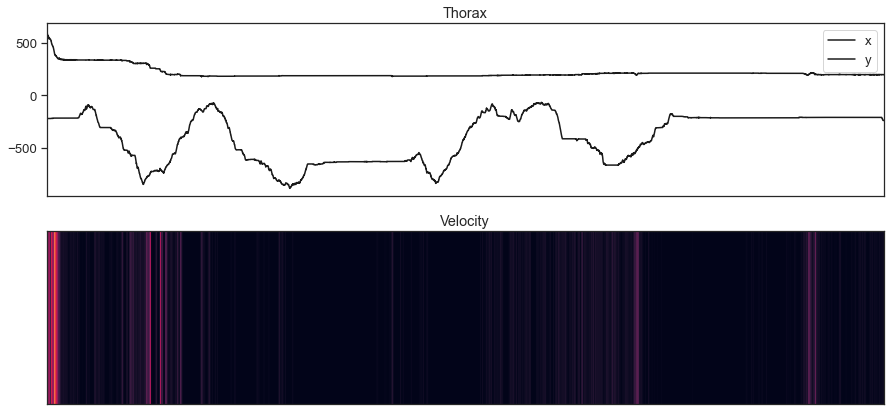

In [148]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thorax_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*thorax_loc[:, 1, 1], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Thorax')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.imshow(thx_vel_fly[:,np.newaxis].T, aspect='auto', vmin=min(thx_vel_fly[:,np.newaxis]), vmax=max(thx_vel_fly[:,np.newaxis]))
ax2.set_yticks([])
ax2.set_title('Velocity')

Text(0.5, 1.0, 'Thorax tracks colored by magnitude of fly speed')

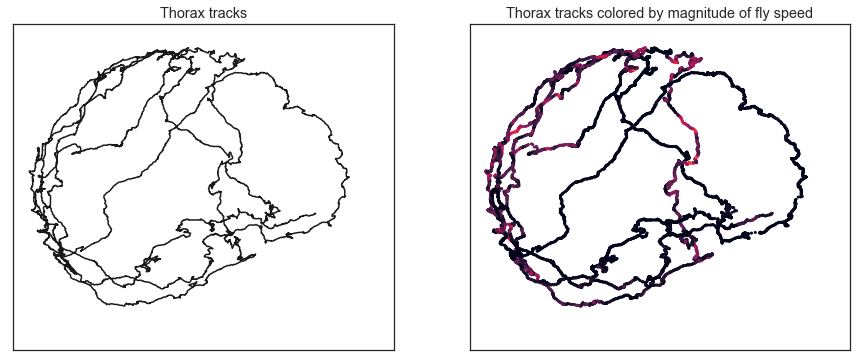

In [154]:
fly_num = 4
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(thorax_loc[:, 0, fly_num], thorax_loc[:, 1, fly_num], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Thorax tracks')

kp = thx_vel_fly1  # use thx_vel_fly1 for other fly
vmin = min(kp)
vmax = max(kp)

ax2 = fig.add_subplot(122)
ax2.scatter(thorax_loc[:,0,fly_num], thorax_loc[:,1,fly_num], c=kp, s=4, vmin=min(kp), vmax=max(kp))
ax2.set_xlim(0,1024)
ax2.set_xticks([])
ax2.set_ylim(0,1024)
ax2.set_yticks([])
ax2.set_title('Thorax tracks colored by magnitude of fly speed')

Text(0.5, 1.0, 'Thorax tracks')

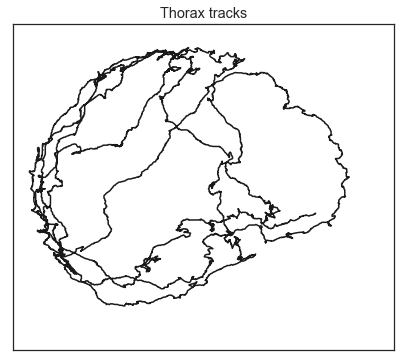

In [157]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(thorax_loc[:, 0, fly_num], thorax_loc[:, 1, fly_num], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Thorax tracks')

In [158]:
locations[time_slice, HEAD_INDEX, :, fly_num]

array([[675.3248291 , 429.33953857],
       [676.44989014, 430.40325928],
       [675.33898926, 431.56140137],
       ...,
       [839.36456299, 445.64413452],
       [839.61224365, 448.34597778],
       [841.24108887, 448.6706543 ]])